# 6. Calibration of double ended measurement with OLS

Use WLS instead. See `examples/notebooks/08Calibrate_double_wls.ipynb`.

A double ended calibration is performed with ordinary least squares. Over all timesteps simultaneous. $\gamma$ and $\int_0^l\alpha$d$x$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance is calculated.

Before starting the calibration procedure, the forward and the backward channel should be aligned.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

/Users/bfdestombe/anaconda3/envs/dts/lib/python3.7/typing.py:847: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds100 = ds.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


In [3]:
print(ds100.calibration_double_ended.__doc__)


        Calibrate the Stokes (`ds.st`) and anti-Stokes (`ds.ast`) of the forward
        channel and from the backward channel (`ds.rst`, `ds.rast`) data to
        temperature using fiber sections with a known temperature
        (`ds.sections`) for double-ended setups. The calibrated temperature of
        the forward channel is stored under `ds.tmpf` and its variance under
        `ds.tmpf_var`, and that of the the backward channel under `ds.tmpb` and
        `ds.tmpb_var`. The inverse-variance weighted average of the forward and
        backward channel is stored under `ds.tmpw` and `ds.tmpw_var`.

        In double-ended setups, Stokes and anti-Stokes intensity is measured in
        two directions from both ends of the fiber. The forward-channel
        measurements are denoted with subscript F, and the backward-channel
        measurements are denoted with subscript B. Both measurement channels
        start at a different end of the fiber and have opposite directions, and
    

In [4]:
ds100.calibration_double_ended(sections=sections,
                               method='ols')

After calibration, two data variables are added to the `DataStore` object:
- `tmpf`, temperature calculated along the forward direction
- `tmpb`, temperature calculated along the backward direction

A better estimate, with a lower expected variance, of the temperature along the fiber is the average of the two. We cannot weigh on more than the other, as we do not have more information about the weighing.

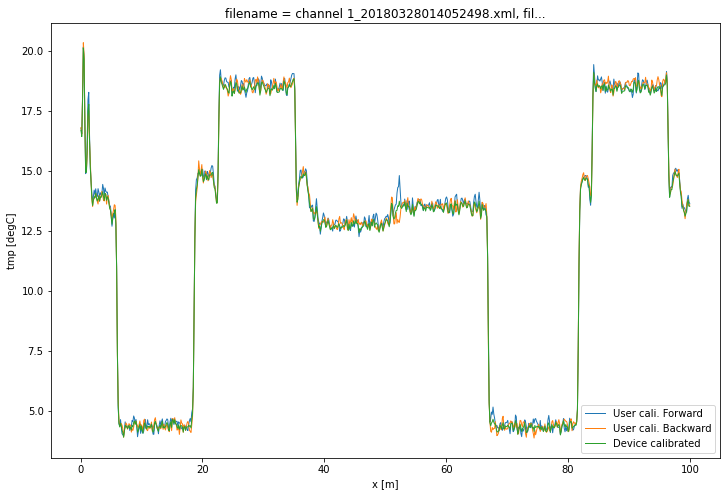

In [5]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.tmpf.plot(linewidth=1, label='User cali. Forward', figsize=(12, 8))  # plot the temperature calibrated by us
ds1.tmpb.plot(linewidth=1, label='User cali. Backward')  # plot the temperature calibrated by us
ds1.tmp.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.legend();

Lets compare our calibrated values with the device calibration. Lets average the temperature of the forward channel and the backward channel first.

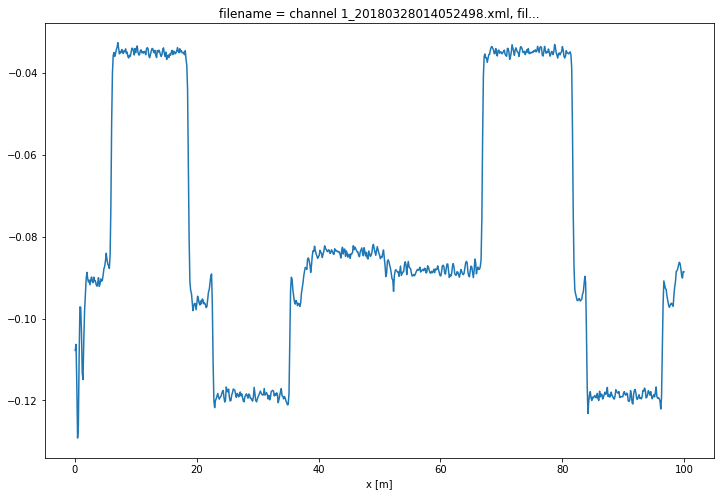

In [6]:
ds1['TMPAVG'] = (ds1.tmpf + ds1.tmpb) / 2
ds1_diff = ds1.tmp - ds1.TMPAVG

ds1_diff.plot(figsize=(12, 8));

The device calibration sections and calibration sections defined by us differ. The device only allows for 2 sections, one per thermometer. And most likely the $\gamma$ is fixed in the device calibration.